In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

pd.options.display.precision = 2 # reduce the defalt display precision to two decimals (this doesn't affect the actual numbers used, only prints?)

# Read in ICA blinks for merged raws from all subjects

In [4]:
eog_peaks = {}
fs_Hz = 64.0

for subjectID in range(1, 21+1):
    npy_path = f'../../data/eog_peaks/merged_raws/eog_peaks_sub{subjectID}_merged_raws.npy'
    arr = np.load(npy_path, allow_pickle=True)
    arr = arr.flat[0]
    eog_peaks[subjectID] = arr[subjectID]


Helper functions to extract relevant info from imported npy ICA data:

In [5]:
# Convert dt object to float seconds
def dtToSeconds(row):
    return row.minute * 60.0 + row.second + (row.microsecond / 1e6)

def descToCondition(row):
    if 'Listening' in row:
        condition = 'Listening' 
    else:
        condition = 'Imagery'
    return condition

def descToChorale(row):
    return row.split('-')[-1]

# Count number of blinks
def countBlinks(subjectID, onset_s, duration, eog_peaks, fs_Hz = 64.0):
    trial_end_s = onset_s + duration
    
    ica_eog_events = np.float64(eog_peaks[subjectID]['ica_eog_events'])
    #print(ica_eog_events)
    ica_eog_events /= fs_Hz
    
    num_blinks = sum((onset_s < ica_eog_events) & (ica_eog_events < trial_end_s))
    return num_blinks

In [6]:
df_all = pd.DataFrame()

for subjectID in eog_peaks:
    # Convert MNE annotations for start/duration time stamp of each trial to a dataframe
    df = eog_peaks[subjectID]['trial_annots'].to_data_frame()

    # Add subjectID as a column (for when we concat all subject dataframes)
    df['subjectID'] = subjectID

    # Drop annotations from merging rawArrays for each trial
    df = df[(df['description'] != 'BAD boundary') & (df['description'] != 'EDGE boundary')]

    # Add trial index as a column
    df['trial'] = range(88)

    # Only retain the time from datetime objects for 'onset'
    df['onset_s'] = df['onset'].apply(
        dtToSeconds
    )

    df['blinks'] = df.apply(
        lambda x: countBlinks(x['subjectID'], x['onset_s'], x['duration'], eog_peaks, fs_Hz), 
        axis = 1,
    )

    df_all = pd.concat([df_all, df])

# Reset row indices so they now count up from 0 to 87 (88 trials total)
df_all.reset_index(
    inplace=True, # modify df indices in place
    drop=True, # do not add a new index column
)

df_all['condition'] = df_all['description'].apply(
    descToCondition,
)

df_all['chorale'] = df_all['description'].apply(
    descToChorale,
)

# Rename "description" (from annotations) to "condition"
# df_all = df_all.rename(columns={"description": "condition"})
df_all

,onset,duration,description,subjectID,trial,onset_s,blinks,condition,chorale
0,1970-01-01 00:00:00.000000,28.16,Listening/chor-096,1,0,0.00,9,Listening,096
1,1970-01-01 00:00:28.171875,28.16,Listening/chor-096,1,1,28.17,4,Listening,096
2,1970-01-01 00:00:56.343750,28.16,Listening/chor-038,1,2,56.34,8,Listening,038
3,1970-01-01 00:01:24.515625,28.16,Listening/chor-038,1,3,84.52,6,Listening,038
4,1970-01-01 00:01:52.687500,28.16,Listening/chor-101,1,4,112.69,4,Listening,101
...,...,...,...,...,...,...,...,...,...
1843,1970-01-01 00:38:58.265625,28.16,Imagery/chor-096,21,83,2338.27,0,Imagery,096
1844,1970-01-01 00:39:26.437500,28.16,Imagery/chor-038,21,84,2366.44,3,Imagery,038
1845,1970-01-01 00:39:54.609375,28.16,Imagery/chor-038,21,85,2394.61,2,Imagery,038
1846,1970-01-01 00:40:22.781250,28.16,Imagery/chor-019,21,86,2422.78,1,Imagery,019


In [7]:
df_all.to_csv('StatBlinks_df_all.csv')

In [10]:
blink_trials = {}
for subjectID in df_all['subjectID'].unique():
    blink_trials[subjectID] = {}

    for condition in df_all['condition'].unique():
        blink_trials[subjectID][condition] = {}

        for chorale in df_all['chorale'].unique():
            blinks = df_all[
                (df_all['subjectID'] == subjectID) &
                (df_all['condition'] == condition) &
                (df_all['chorale'] == chorale)
            ]['blinks']

            blinks = np.array(blinks)
            blink_trials[subjectID][condition][chorale] = blinks            
  
print(blink_trials)

{1: {'Listening': {'096': array([ 9,  4,  8,  5,  7,  5,  7,  5, 11, 13,  8]), '038': array([ 8,  6,  4, 10,  5,  8,  6,  7, 10,  6, 13]), '101': array([ 4,  5,  9,  6,  9, 10,  7,  7,  7,  6,  8]), '019': array([ 3,  6,  7,  5,  6,  3,  6,  4, 11,  9,  7])}, 'Imagery': {'096': array([3, 4, 6, 6, 6, 5, 7, 7, 9, 7, 9]), '038': array([ 5, 13,  7,  8,  6, 10, 10,  5,  9,  8, 12]), '101': array([4, 7, 5, 5, 7, 5, 5, 4, 8, 6, 7]), '019': array([3, 5, 3, 5, 5, 3, 3, 4, 6, 0, 4])}}, 2: {'Listening': {'096': array([1, 0, 0, 0, 5, 0, 1, 0, 0, 0, 0]), '038': array([0, 2, 0, 1, 0, 0, 1, 2, 1, 0, 0]), '101': array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]), '019': array([0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1])}, 'Imagery': {'096': array([0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0]), '038': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]), '101': array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]), '019': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])}}, 3: {'Listening': {'096': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), '038': array([0, 0, 1, 0, 0

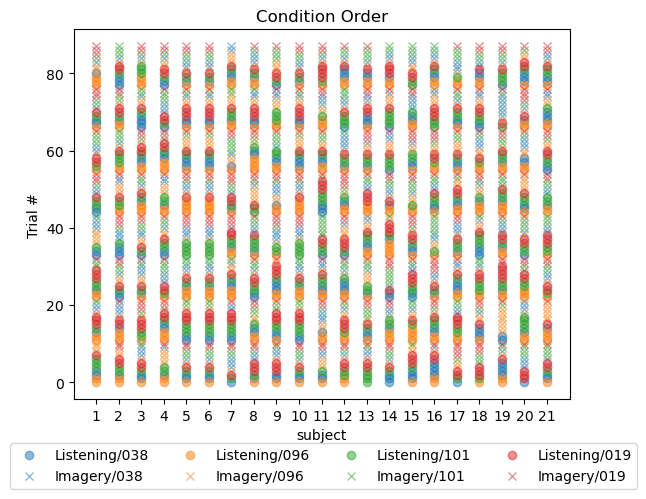

In [5]:
fig, ax = plt.subplots()

ch_x_offset = 0
for chorale in ['038', '096', '101', '019']:
    df = df_all[(df_all['condition'] == 'Listening') & (df_all['chorale'] == chorale)]
    line, = ax.plot(
        df['subjectID'] + (1/8)*ch_x_offset,
        df['trial'],
        marker = 'o',
        ls = '',
        label = f'Listening/{chorale}',
        alpha=0.5,
    )

    df = df_all[(df_all['condition'] == 'Imagery') & (df_all['chorale'] == chorale)]
    ax.plot(
        df['subjectID'] + (2/8)*ch_x_offset,
        df['trial'],
        marker = 'x',
        ls = '',
        c = line.get_color(),
        label = f'Imagery/{chorale}',
        alpha=0.5,
    )

    ch_x_offset += 0 #1

plt.xticks(
    ticks = range(1, 21+1)
)
plt.title('Condition Order')
plt.xlabel('subject')
plt.ylabel('Trial #')
plt.legend(bbox_to_anchor=(1.15, -0.1), ncols = 4)
plt.show()

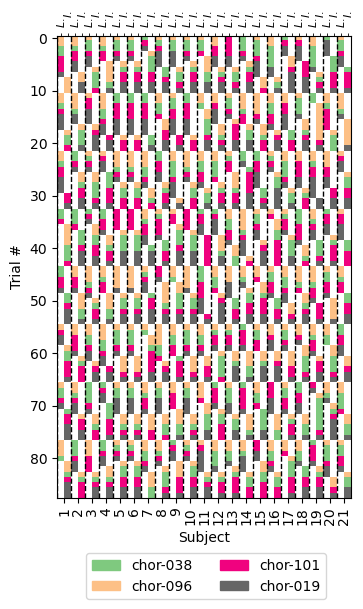

In [6]:
# https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(8, 6))

# https://stackoverflow.com/a/26693107
design_matrix = np.nan * np.ones(shape=(21*2, 88)) # make nan so unused pixels can be colored using set_bad below
chorales = {
    0: '038',
    1: '096',
    2: '101',
    3: '019',
}
conditions = {
    0: 'Listening',
    1: 'Imagery'
}

i = 0
for subjectID in range(21):
    for condID in range(2):
        for chorID in range(4):
            chorale = chorales[chorID]
            condition = conditions[condID]
            df = df_all[
                (df_all['subjectID'] == subjectID+1) &
                (df_all['condition'] == condition) & 
                (df_all['chorale'] == chorale)
                ]
            #print(i, chorID, condID, subjectID+1, condition, chorale)
            #print(df)
            trial_idxs = np.array(df['trial'])
            #print(trial_idxs)
            design_matrix[i, trial_idxs] = chorID
        i += 1 # update to track condition

cmap = plt.cm.Accent
cmap.set_bad((0, 0, 0, 0))

im = ax.imshow(
    design_matrix.T, 
    cmap = cmap, 
    interpolation=None,
    aspect = .75,
    #norm = None,
    #vmin = 0,
    #vmax = 1,
    filternorm = False,
)

# get the colors of the values, according to the 
# colormap used by imshow
values = range(4)
colors = [im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [] #mpatches.Patch(color=(1, 1, 1, 1)) for i in range(1)]
patches.extend([mpatches.Patch(color=colors[i], label=f'chor-{chorales[i]}') for i in range(len(values))])

# put those patched as legend-handles into the legend
plt.legend(
    handles=patches, 
    bbox_to_anchor=(.1, -.12), 
    ncols = 2,
    loc=2, 
    borderaxespad=0. )

for x in range(21):
    ax.axvline(
        x=2*x -0.5,
        c = 'k',
        linewidth = 1,
        ls = '--',
    )

plt.xticks(
    ticks = np.arange(0.5, 42, 2),
    labels = range(1, 21+1),
    rotation = 90,
)
plt.xticks(
    ticks = np.arange(0, 42, 1),
    labels = ['$L.$', '   $I.$']*21,
    rotation = 90,
    minor=True,
    fontsize = 8,
)
plt.tick_params(axis='x', 
                which='minor', 
                top=True, 
                labeltop = True,
                bottom=False,
                labelbottom = False,
                )
plt.xlabel('Subject')
plt.ylabel('Trial #')
plt.show()

In [7]:
dir(im)

['_A',
 '_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alpha',
 '_animated',
 '_axes',
 '_callbacks',
 '_check_unsampled_image',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_default_contains',
 '_extent',
 '_filternorm',
 '_filterrad',
 '_fully_clipped_to_axes',
 '_get_scalar_alpha',
 '_gid',
 '_id_norm',
 '_imcache',
 '_in_layout',
 '_internal_update',
 '_interpolation',
 '_interpolation_stage',
 '_label',
 '_make_image',
 '_mouseover',
 '_norm',
 '_path_effects',
 '_picker',
 '_rasterized',
 '_remove_method',
 '_resample',
 '_scale_norm',
 '_set_alpha_for_array',
 '_set_gc_clip',
 '_sketch',
 '_snap',
 

# Pivot Table To Get Mean / Median Blink Counts
By condition (description) and subject

In [13]:
df_pivot = pd.pivot_table(
    df_all,
    values = 'blinks',
    index = 'subjectID',
    columns = ['condition', 'chorale'],
    aggfunc = ['mean', 'median', 'sum']
)

df_pivot

mean                                                     median  \
condition Imagery                     Listening                      Imagery   
chorale       019    038    096   101       019    038    096    101     019   
subjectID                                                                      
1            3.73   8.45   6.27  5.73      6.09   7.55   7.45   7.09       4   
2            0.09   0.18   0.36  0.18      0.36   0.64   0.64   0.18       0   
3            0.00   0.00   0.00  0.09      0.36   0.18   0.09   0.09       0   
4            3.09   3.64   2.45  3.73      3.64   7.82   4.27   7.27       2   
5            0.64   1.00   0.55  0.27      0.45   1.27   0.91   2.64       0   
6            1.55   6.09   4.18  3.18      1.91   5.73   6.55   3.45       1   
7            3.73  14.09  10.27  4.45      6.64  14.82  12.82   6.27       3   
8            4.00   2.45   4.64  3.36      6.27   4.91   5.82   6.55       3   
9            1.36   1.00   1.64  0.91      2.64   1.82   1.91   0.73       1   
10           0.09   0.55   0.27  0.27      0.09   1.18   0.27   0.09       0   
11           3.36   5.18   5.82  2.91      3.27   5.55   6.00   5.09       3   
12           1.91   2.36   1.00  1.64      0.91   2.09   1.45   0.55       0   
13           0.36   0.55   0.91  0.36      2.27   4.73   3.64   3.00       0   
14           0.00   0.09   0.18  0.00      0.45   3.64   1.18   0.27       0   
15           0.27   0.73   0.27  0.45      0.09   0.36   0.18   0.55       0   
16           0.00   0.09   0.00  0.00      0.00   0.00   0.00   0.09       0   
17           3.00   4.55   5.55  4.82     11.00  11.09  20.09  11.00       3   
18           0.36   0.55   0.09  0.82      1.36   0.82   0.64   0.73       0   
19           0.64   1.09   1.27  0.36      1.00   1.64   0.55   1.27       0   
20           0.55   1.00   0.55  1.18      0.55   1.36   1.09   1.09       0   
21           0.73   1.82   1.09  2.00      2.00   4.00   1.00   1.55       1   

               ...                   sum                                    \
condition      ... Listening     Imagery               Listening             
chorale   038  ...       096 101     019  038  096 101       019  038  096   
subjectID      ...                                                           
1           8  ...         7   7      41   93   69  63        67   83   82   
2           0  ...         0   0       1    2    4   2         4    7    7   
3           0  ...         0   0       0    0    0   1         4    2    1   
4           3  ...         5   8      34   40   27  41        40   86   47   
5           1  ...         1   1       7   11    6   3         5   14   10   
6           5  ...         5   2      17   67   46  35        21   63   72   
7          14  ...        12   5      41  155  113  49        73  163  141   
8           2  ...         5   6      44   27   51  37        69   54   64   
9           1  ...         1   1      15   11   18  10        29   20   21   
10          0  ...         0   0       1    6    3   3         1   13    3   
11          5  ...         5   5      37   57   64  32        36   61   66   
12          2  ...         1   0      21   26   11  18        10   23   16   
13          0  ...         4   3       4    6   10   4        25   52   40   
14          0  ...         1   0       0    1    2   0         5   40   13   
15          0  ...         0   0       3    8    3   5         1    4    2   
16          0  ...         0   0       0    1    0   0         0    0    0   
17          3  ...        22   8      33   50   61  53       121  122  221   
18          1  ...         0   1       4    6    1   9        15    9    7   
19          1  ...         0   1       7   12   14   4        11   18    6   
20          1  ...         1   1       6   11    6  13         6   15   12   
21          2  ...         1   2       8   20   12  22        22   44   11   

                
condition       
chorale    101  
subjectID 

In [14]:
# Sort subjectIDs by sum of blinks
conds_in_asc_blink_sum = df_pivot['sum'].sum(axis=0).sort_values().index
conds_in_asc_blink_sum

MultiIndex([(  'Imagery', '019'),
            (  'Imagery', '101'),
            (  'Imagery', '096'),
            ('Listening', '019'),
            (  'Imagery', '038'),
            ('Listening', '101'),
            ('Listening', '096'),
            ('Listening', '038')],
           names=['condition', 'chorale'])

In [15]:
subjectIDs_in_asc_blink_sum = df_pivot['sum'].sum(axis=1).sort_values().index
subjectIDs_in_asc_blink_sum

Int64Index([16, 3, 2, 10, 15, 18, 14, 20, 5, 19, 12, 9, 21, 13, 6, 4, 11, 8, 1,
            17, 7],
           dtype='int64', name='subjectID')

In [16]:
df_pivot['mean'][conds_in_asc_blink_sum]

condition Imagery              Listening Imagery Listening              
chorale       019   101    096       019     038       101    096    038
subjectID                                                               
1            3.73  5.73   6.27      6.09    8.45      7.09   7.45   7.55
2            0.09  0.18   0.36      0.36    0.18      0.18   0.64   0.64
3            0.00  0.09   0.00      0.36    0.00      0.09   0.09   0.18
4            3.09  3.73   2.45      3.64    3.64      7.27   4.27   7.82
5            0.64  0.27   0.55      0.45    1.00      2.64   0.91   1.27
6            1.55  3.18   4.18      1.91    6.09      3.45   6.55   5.73
7            3.73  4.45  10.27      6.64   14.09      6.27  12.82  14.82
8            4.00  3.36   4.64      6.27    2.45      6.55   5.82   4.91
9            1.36  0.91   1.64      2.64    1.00      0.73   1.91   1.82
10           0.09  0.27   0.27      0.09    0.55      0.09   0.27   1.18
11           3.36  2.91   5.82      3.27    5.18      5.09   6.00   5.55
12           1.91  1.64   1.00      0.91    2.36      0.55   1.45   2.09
13           0.36  0.36   0.91      2.27    0.55      3.00   3.64   4.73
14           0.00  0.00   0.18      0.45    0.09      0.27   1.18   3.64
15           0.27  0.45   0.27      0.09    0.73      0.55   0.18   0.36
16           0.00  0.00   0.00      0.00    0.09      0.09   0.00   0.00
17           3.00  4.82   5.55     11.00    4.55     11.00  20.09  11.09
18           0.36  0.82   0.09      1.36    0.55      0.73   0.64   0.82
19           0.64  0.36   1.27      1.00    1.09      1.27   0.55   1.64
20           0.55  1.18   0.55      0.55    1.00      1.09   1.09   1.36
21           0.73  2.00   1.09      2.00    1.82      1.55   1.00   4.00

In [17]:
df_pivot['mean'].loc[subjectIDs_in_asc_blink_sum, conds_in_asc_blink_sum]

condition Imagery              Listening Imagery Listening              
chorale       019   101    096       019     038       101    096    038
subjectID                                                               
16           0.00  0.00   0.00      0.00    0.09      0.09   0.00   0.00
3            0.00  0.09   0.00      0.36    0.00      0.09   0.09   0.18
2            0.09  0.18   0.36      0.36    0.18      0.18   0.64   0.64
10           0.09  0.27   0.27      0.09    0.55      0.09   0.27   1.18
15           0.27  0.45   0.27      0.09    0.73      0.55   0.18   0.36
18           0.36  0.82   0.09      1.36    0.55      0.73   0.64   0.82
14           0.00  0.00   0.18      0.45    0.09      0.27   1.18   3.64
20           0.55  1.18   0.55      0.55    1.00      1.09   1.09   1.36
5            0.64  0.27   0.55      0.45    1.00      2.64   0.91   1.27
19           0.64  0.36   1.27      1.00    1.09      1.27   0.55   1.64
12           1.91  1.64   1.00      0.91    2.36      0.55   1.45   2.09
9            1.36  0.91   1.64      2.64    1.00      0.73   1.91   1.82
21           0.73  2.00   1.09      2.00    1.82      1.55   1.00   4.00
13           0.36  0.36   0.91      2.27    0.55      3.00   3.64   4.73
6            1.55  3.18   4.18      1.91    6.09      3.45   6.55   5.73
4            3.09  3.73   2.45      3.64    3.64      7.27   4.27   7.82
11           3.36  2.91   5.82      3.27    5.18      5.09   6.00   5.55
8            4.00  3.36   4.64      6.27    2.45      6.55   5.82   4.91
1            3.73  5.73   6.27      6.09    8.45      7.09   7.45   7.55
17           3.00  4.82   5.55     11.00    4.55     11.00  20.09  11.09
7            3.73  4.45  10.27      6.64   14.09      6.27  12.82  14.82

In [18]:
stim_order = [
    ('Listening', '038'),
    ('Listening', '096'),
    ('Listening', '101'),
    ('Listening', '019'), 
    ('Imagery', '038'), 
    ('Imagery', '096'),
    ('Imagery', '101'), 
    ('Imagery', '019'), 
]

In [19]:
df_pivot['mean'].loc[subjectIDs_in_asc_blink_sum, stim_order].style.background_gradient(
    cmap ='bwr',
    axis = 1,
).set_properties() #**{'font-size': '20px'}) 
# https://www.geeksforgeeks.org/display-the-pandas-dataframe-in-heatmap-style/ 

In [20]:
print(df_pivot['median'].loc[subjectIDs_in_asc_blink_sum, stim_order].style.background_gradient(
    cmap ='bwr',
    axis = 1,
).to_latex(
        convert_css = True,
        column_format="r|c|c|c|c|c|c|c|c|",
        #hrules = True,
        clines = 'all;data',
        #multicol_align = {'c'},
    )
)

df_pivot['median'].loc[subjectIDs_in_asc_blink_sum, stim_order].style.background_gradient(
    cmap ='bwr',
    axis = 1,
)

\begin{tabular}{r|c|c|c|c|c|c|c|c|}
condition & \multicolumn{4}{r}{Listening} & \multicolumn{4}{r}{Imagery} \\
chorale & 038 & 096 & 101 & 019 & 038 & 096 & 101 & 019 \\
subjectID &  &  &  &  &  &  &  &  \\
16 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 \\
\cline{1-9}
3 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F

In [21]:
print(df_pivot['sum'].loc[subjectIDs_in_asc_blink_sum, stim_order].style.background_gradient(
    cmap ='magma',
    axis = 1,
).to_latex(
    convert_css = True,
    column_format="r|c|c|c|c|c|c|c|c|",
    #hrules = True,
    clines = 'all;data',
    #multicol_align = {'c'},
    )
)

df_pivot['sum'].loc[subjectIDs_in_asc_blink_sum, stim_order].style.background_gradient(
    cmap ='magma',
    axis = 1,
)

\begin{tabular}{r|c|c|c|c|c|c|c|c|}
condition & \multicolumn{4}{r}{Listening} & \multicolumn{4}{r}{Imagery} \\
chorale & 038 & 096 & 101 & 019 & 038 & 096 & 101 & 019 \\
subjectID &  &  &  &  &  &  &  &  \\
16 & {\cellcolor[HTML]{000004}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{000004}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{FCFDBF}} \color[HTML]{000000} 1 & {\cellcolor[HTML]{000004}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{FCFDBF}} \color[HTML]{000000} 1 & {\cellcolor[HTML]{000004}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{000004}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{000004}} \color[HTML]{F1F1F1} 0 \\
\cline{1-9}
3 & {\cellcolor[HTML]{B73779}} \color[HTML]{F1F1F1} 2 & {\cellcolor[HTML]{51127C}} \color[HTML]{F1F1F1} 1 & {\cellcolor[HTML]{51127C}} \color[HTML]{F1F1F1} 1 & {\cellcolor[HTML]{FCFDBF}} \color[HTML]{000000} 4 & {\cellcolor[HTML]{000004}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{000004}} \color[HTML]{F1F1F1} 0 & {\cellcolor[HTML]{51127C}} \color[HTML]{F1F

In [22]:
df_pivot['median'][stim_order]

condition Listening             Imagery            
chorale         038 096 101 019     038 096 101 019
subjectID                                          
1                 7   7   7   6       8   6   5   4
2                 0   0   0   0       0   0   0   0
3                 0   0   0   0       0   0   0   0
4                 8   5   8   2       3   2   3   2
5                 1   1   1   0       1   0   0   0
6                 6   5   2   2       5   4   3   1
7                17  12   5   5      14  13   4   3
8                 5   5   6   5       2   5   3   3
9                 2   1   1   1       1   2   1   1
10                1   0   0   0       0   0   0   0
11                5   5   5   3       5   6   3   3
12                2   1   0   1       2   1   1   0
13                5   4   3   2       0   1   0   0
14                3   1   0   0       0   0   0   0
15                0   0   0   0       0   0   0   0
16                0   0   0   0       0   0   0   0
17               12  22   8  10       3   5   3   3
18                1   0   1   1       1   0   1   0
19                1   0   1   1       1   1   0   0
20                1   1   1   1       1   0   1   0
21                4   1   2   2       2   1   2   1

In [23]:
df_pivot.index

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20, 21],
           dtype='int64', name='subjectID')

# Normalize each trial's blink count 
using subjects' avg. blink count over all trials 

In [24]:
def normBlinks(subjectID, blinks, df_all, numTrials = 88):
    blinkSum = df_all[df_all['subjectID'] == subjectID]['blinks'].sum()
    return blinks / (blinkSum / numTrials) # now this is just scaling the subject's avg. blink rate

df_all['blinks_norm'] = df_all.apply(
    lambda x: normBlinks(x['subjectID'], x['blinks'], df_all, 88),
    axis = 1,
)

In [25]:
df_all

,onset,duration,description,subjectID,trial,onset_s,blinks,condition,chorale,blinks_norm
0,1970-01-01 00:00:00.000000,28.16,Listening/chor-096,1,0,0.00,9,Listening,096,1.38
1,1970-01-01 00:00:28.171875,28.16,Listening/chor-096,1,1,28.17,4,Listening,096,0.61
2,1970-01-01 00:00:56.343750,28.16,Listening/chor-038,1,2,56.34,8,Listening,038,1.22
3,1970-01-01 00:01:24.515625,28.16,Listening/chor-038,1,3,84.52,6,Listening,038,0.92
4,1970-01-01 00:01:52.687500,28.16,Listening/chor-101,1,4,112.69,4,Listening,101,0.61
...,...,...,...,...,...,...,...,...,...,...
1843,1970-01-01 00:38:58.265625,28.16,Imagery/chor-096,21,83,2338.27,0,Imagery,096,0.00
1844,1970-01-01 00:39:26.437500,28.16,Imagery/chor-038,21,84,2366.44,3,Imagery,038,1.69
1845,1970-01-01 00:39:54.609375,28.16,Imagery/chor-038,21,85,2394.61,2,Imagery,038,1.13
1846,1970-01-01 00:40:22.781250,28.16,Imagery/chor-019,21,86,2422.78,1,Imagery,019,0.56


In [26]:
df_pivot_norm = pd.pivot_table(
    df_all,
    values = 'blinks_norm',
    index = 'subjectID',
    columns = ['condition', 'chorale'],
    aggfunc = ['mean', 'median', 'sum']
)

df_pivot_norm

mean                                                median        \
condition Imagery                   Listening                   Imagery         
chorale       019   038   096   101       019   038   096   101     019   038   
subjectID                                                                       
1            0.57  1.29  0.96  0.88      0.93  1.15  1.14  1.08    0.61  1.22   
2            0.28  0.55  1.10  0.55      1.10  1.93  1.93  0.55    0.00  0.00   
3            0.00  0.00  0.00  0.89      3.56  1.78  0.89  0.89    0.00  0.00   
4            0.69  0.81  0.55  0.83      0.81  1.74  0.95  1.62    0.45  0.67   
5            0.66  1.04  0.56  0.28      0.47  1.32  0.94  2.73    0.00  1.04   
6            0.38  1.49  1.03  0.78      0.47  1.40  1.60  0.85    0.25  1.23   
7            0.41  1.54  1.12  0.49      0.73  1.62  1.40  0.69    0.33  1.53   
8            0.84  0.52  0.98  0.71      1.32  1.03  1.22  1.38    0.63  0.42   
9            0.91  0.67  1.09  0.61      1.76  1.21  1.27  0.48    0.67  0.67   
10           0.26  1.55  0.77  0.77      0.26  3.35  0.77  0.26    0.00  0.00   
11           0.72  1.11  1.25  0.63      0.70  1.19  1.29  1.10    0.65  1.08   
12           1.28  1.59  0.67  1.10      0.61  1.40  0.98  0.37    0.00  1.34   
13           0.18  0.28  0.46  0.18      1.15  2.39  1.84  1.52    0.00  0.00   
14           0.00  0.12  0.25  0.00      0.62  5.00  1.62  0.38    0.00  0.00   
15           0.75  2.00  0.75  1.25      0.25  1.00  0.50  1.50    0.00  0.00   
16           0.00  4.00  0.00  0.00      0.00  0.00  0.00  4.00    0.00  0.00   
17           0.34  0.51  0.62  0.54      1.24  1.25  2.26  1.24    0.34  0.34   
18           0.54  0.81  0.14  1.22      2.03  1.22  0.95  1.08    0.00  1.49   
19           0.65  1.12  1.30  0.37      1.02  1.67  0.56  1.30    0.00  1.02   
20           0.59  1.09  0.59  1.28      0.59  1.48  1.19  1.19    0.00  1.09   
21           0.41  1.03  0.62  1.13      1.13  2.26  0.56  0.87    0.56  1.13   

           ...                     sum                                        \
condition  ... Listening       Imagery                      Listening          
chorale    ...       096   101     019    038    096    101       019    038   
subjectID  ...                                                                 
1          ...      1.07  1.07    6.26  14.21  10.54   9.62     10.24  12.68   
2          ...      0.00  0.00    3.03   6.07  12.14   6.07     12.14  21.24   
3          ...      0.00  0.00    0.00   0.00   0.00   9.78     39.11  19.56   
4          ...      1.11  1.78    7.57   8.91   6.02   9.13      8.91  19.16   
5          ...      1.04  1.04    7.25  11.39   6.21   3.11      5.18  14.49   
6          ...      1.23  0.49    4.17  16.42  11.28   8.58      5.15  15.44   
7          ...      1.31  0.55    4.49  16.97  12.37   5.36      7.99  17.84   
8          ...      1.05  1.26    9.26   5.68  10.74   7.79     14.53  11.37   
9          ...      0.67  0.67   10.00   7.33  12.00   6.67     19.33  13.33   
10         ...      0.00  0.00    2.84  17.03   8.52   8.52      2.84  36.90   
11         ...      1.08  1.08    7.96  12.26  13.77   6.89      7.75  13.12   
12         ...      0.67  0.00   14.11  17.47   7.39  12.09      6.72  15.45   
13         ...      2.02  1.52    2.02   3.03   5.06   2.02     12.64  26.30   
14         ...      1.38  0.00    0.00   1.38   2.75   0.00      6.88  55.00   
15         ...      0.00  0.00    8.25  22.00   8.25  13.75      2.75  11.00   
16         ...      0.00  0.00    0.00  44.00   0.00   0.00      0.00   0.00   
17         ...      2.48  0.90    3.71   5.63   6.86   5.96     13.62  13.73   
18         ...      0.00  1.49    5.97   8.95   1.49  13.42     22.37  13.42   
19         ...      0.00  1.02    7.16  12.28  14.33   4.09     11.26  18.42   
20         ...      1.09  1.09    6.52  11.95   6.52  14.12      6.52  16.30   
21         ...      0.56  1.13    4.51  11.28   6.77  12.41     12.

In [27]:
method = 'mean'
cmap = 'bwr'
vmin = 0
vmax = 2
precision = 1

print(df_pivot_norm[method].loc[subjectIDs_in_asc_blink_sum, stim_order].style.set_precision(precision).background_gradient(
    cmap = cmap,
    vmin = vmin,
    vmax= 2,
    #axis = 1,
).to_latex(
        convert_css = True,
        column_format="r|c|c|c|c|c|c|c|c|",
        #hrules = True,
        clines = 'all;data',
        #multicol_align = {'c'},
    )
)

df_pivot_norm[method].loc[subjectIDs_in_asc_blink_sum, stim_order].style.set_precision(precision).background_gradient(
    cmap =cmap,
    vmin = vmin,
    vmax= vmax,
    #axis = 1,
)

\begin{tabular}{r|c|c|c|c|c|c|c|c|}
condition & \multicolumn{4}{r}{Listening} & \multicolumn{4}{r}{Imagery} \\
chorale & 038 & 096 & 101 & 019 & 038 & 096 & 101 & 019 \\
subjectID &  &  &  &  &  &  &  &  \\
16 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0.0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0.0 & {\cellcolor[HTML]{FF0000}} \color[HTML]{F1F1F1} 4.0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0.0 & {\cellcolor[HTML]{FF0000}} \color[HTML]{F1F1F1} 4.0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0.0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0.0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0.0 \\
\cline{1-9}
3 & {\cellcolor[HTML]{FF3838}} \color[HTML]{F1F1F1} 1.8 & {\cellcolor[HTML]{E2E2FF}} \color[HTML]{000000} 0.9 & {\cellcolor[HTML]{E2E2FF}} \color[HTML]{000000} 0.9 & {\cellcolor[HTML]{FF0000}} \color[HTML]{F1F1F1} 3.6 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0.0 & {\cellcolor[HTML]{0000FF}} \color[HTML]{F1F1F1} 0.0 & {\cellcolor[HTM

/var/folders/st/wjnxghxn7_b382gv3l4lxt0m0000gn/T/ipykernel_13649/557030774.py:7: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  print(df_pivot_norm[method].loc[subjectIDs_in_asc_blink_sum, stim_order].style.set_precision(precision).background_gradient(
/var/folders/st/wjnxghxn7_b382gv3l4lxt0m0000gn/T/ipykernel_13649/557030774.py:21: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df_pivot_norm[method].loc[subjectIDs_in_asc_blink_sum, stim_order].style.set_precision(precision).background_gradient(


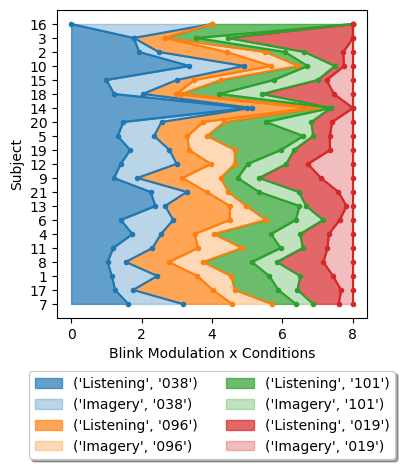

In [28]:
stim_order_stack = [
    ('Listening', '038'),
    ('Imagery', '038'), 
    ('Listening', '096'),
    ('Imagery', '096'),
    ('Listening', '101'),
    ('Imagery', '101'), 
    ('Listening', '019'), 
    ('Imagery', '019'), 
]

fig, ax = plt.subplots(figsize = (4,4))

x = np.zeros_like(df_pivot_norm['mean'][stim_order[0]])
c = {}
for stim in stim_order_stack:
    y = range(1, 21+1)
    del_x = df_pivot_norm['mean'].loc[subjectIDs_in_asc_blink_sum, stim]

    condition = stim[0]
    chorale = stim[1]
    if condition == 'Listening':
        marker = '.'
        alpha = 0.7
    elif condition == 'Imagery':
        marker = '.'
        alpha = 0.3
        
    if chorale in c:
        line, = plt.plot(
            x + del_x,
            y,
            marker=marker,
            c = c[chorale],
        )
    else:
        line, = plt.plot(
            x + del_x,
            y,
            marker=marker,
        )
        c[chorale] = line.get_color()

    plt.fill_betweenx(
        y,
        x,
        x + del_x,
        color = c[chorale],
        alpha = alpha,
        label = stim,
    )
    
    x += del_x

plt.legend(
    loc='upper center', bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2
)
#plt.xticks(rotation=90)
plt.yticks(
    ticks = range(1, 21+1),
    labels= subjectIDs_in_asc_blink_sum, #x, #range(1, 21+1),
    #rotation = 90,
)
#plt.yscale('log')
plt.xlabel('Blink Modulation x Conditions')
plt.ylabel('Subject')
ax.invert_yaxis()
plt.show()

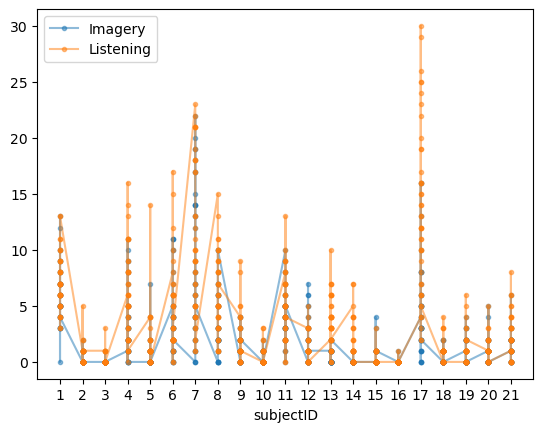

In [29]:
fig, ax = plt.subplots()

for name, group in df_all.groupby(['condition']):
    group.plot(
        x = 'subjectID',
        y = 'blinks',
        marker = '.',
        ls = '-',
        ax = ax,
        alpha = 0.5,
        label = name,
    )
plt.xticks(
    ticks = range(1, 21+1),
    labels= range(1, 21+1),
)

plt.show()

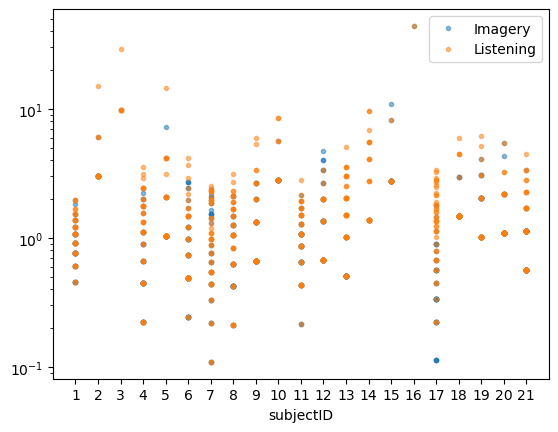

In [30]:
fig, ax = plt.subplots()

for name, group in df_all.groupby(['condition']):
    group.plot(
        x = 'subjectID',
        y = 'blinks_norm',
        marker = '.',
        ls = '',
        ax = ax,
        alpha = 0.5,
        label = name,
        logy = True,
    )

#plt.ylim([0, 10])
plt.xticks(
    ticks = range(1, 21+1),
    labels= range(1, 21+1),
)

plt.show()

(0.0, 5.0)

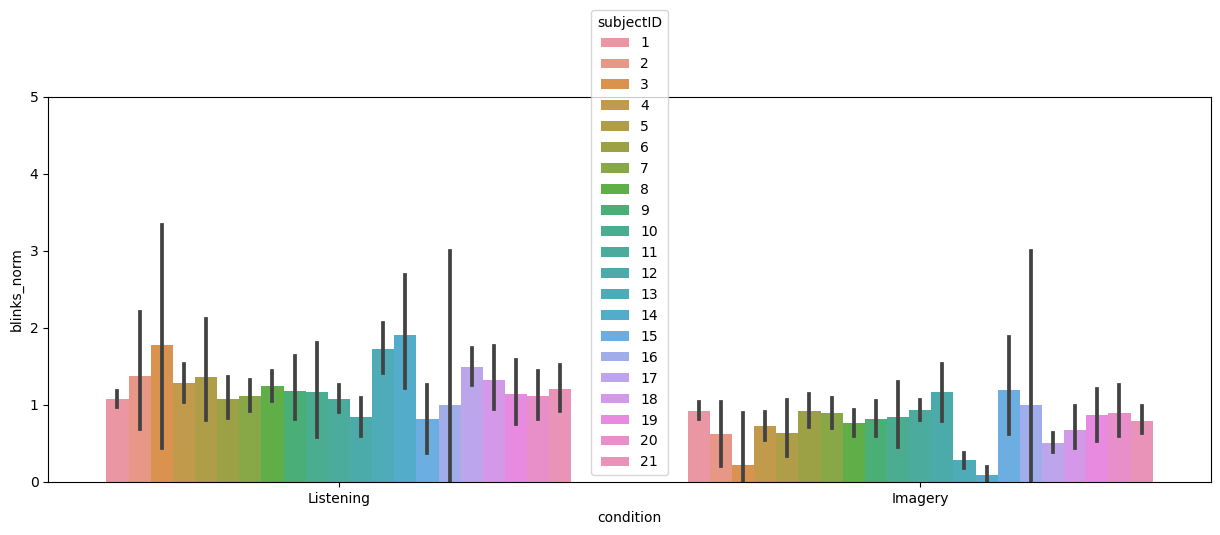

In [31]:
import seaborn as sb

# https://www.tutorialspoint.com/python-pandas-draw-vertical-bar-plots-with-nested-grouping-by-two-categorical-variables-in-seaborn


fig, ax = plt.subplots(figsize=(15, 5))

sb.barplot(
    x = df_all['condition'],
    y = df_all['blinks_norm'],
    hue = 'subjectID',
    data = df_all,
    ax = ax,
    #stacked = True,
)

ax.set_ylim([0, 5])

# Appendix

In [ ]:
# Taking in the subject data, each condition (see map) is the key for a
# blink value that is the number of blinks in the duration of the trial
npy_path = 'Subject1BlinksData.npy'
arr = np.load(npy_path, allow_pickle=True)
arr = arr.flat[0]

In [ ]:
# Numerical map for each of the song and listening or imagining conditions
Listeningchor96_Indexes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Imaginingchor96_Indexes = [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]

Listeningchor38_Indexes = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Imaginingchor38_Indexes = [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]

Listeningchor101_Indexes = [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
Imaginingchor101_Indexes = [66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]

Listeningchor19_Indexes = [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
Imaginingchor19_Indexes = [77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]

chors = [Listeningchor19_Indexes,Listeningchor38_Indexes,Listeningchor96_Indexes,Listeningchor101_Indexes,
         Imaginingchor19_Indexes,Imaginingchor38_Indexes,Imaginingchor96_Indexes,Imaginingchor101_Indexes]

In [ ]:
# Creating 2D array with rows equal to the number of chors and conditions and cols equal to test number
ConditionArray = np.empty([len(chors),len(chors[1])], dtype=int)

# Filling 2D ndarray with blink info row corresponds to L/I + chor##
# and col is the number of blinks in one of the 11 trials
rowi = 0
for chorindexes in chors:

    coli = 0
    for key in chorindexes:
        ConditionArray[rowi, coli] = arr[key]
        coli += 1

    rowi += 1


# Running statistical analysis with student's t. Comparing each condition to all others
# Array for storing the tstatistic and pval results as a list with [tstat, pval]
StatArray_t = np.empty([8,8], dtype = list)
StatArray_p = np.empty([8,8], dtype = list)

# Conducting two-tailed t test as the null hypothesis is that there is difference between the distributions
# Each distribution will be compared against all other distributions, including itself
rowi = 0
for Row in ConditionArray:
    for trialIdx in range(len(Row)):
        if trialIdx == 0:
            alpha = 1
            trial, = plt.plot(
                rowi, Row[trialIdx], 
                '.', 
                alpha = alpha, #1-trialIdx/len(Row)
            )
        else:
            alpha = 1-trialIdx/len(Row)
            plt.plot(
                rowi, Row[trialIdx], 
                '.', 
                alpha = alpha,
                c=trial.get_color(),
            )
    plt.plot(rowi, np.mean(Row), 'x', c=trial.get_color())

    coli = 0
    for Col in ConditionArray:

        t_statistic, p_value = ttest_ind(Row, Col)
        
        StatArray_t[rowi, coli] = t_statistic
        StatArray_p[rowi, coli] = p_value
        coli += 1

    rowi += 1


# print(StatArray)


# Converting StatArray to a dataframe for easy analysis

df_t = pd.DataFrame(StatArray_t)
df_p = pd.DataFrame(StatArray_p)

chors = [Listeningchor19_Indexes,Listeningchor38_Indexes,Listeningchor96_Indexes,Listeningchor101_Indexes,
         Imaginingchor19_Indexes,Imaginingchor38_Indexes,Imaginingchor96_Indexes,Imaginingchor101_Indexes]

plt.xticks(
    ticks=range(rowi), 
    labels=['Listeningchor19', 'Listeningchor38', 'Listeningchor96', 'Listeningchor101',
            'Imaginingchor19', 'Imaginingchor38', 'Imaginingchor96', 'Imaginingchor101'],
    rotation='vertical'
)
plt.ylabel('#Blinks')
plt.title(npy_path)
plt.show()

# Rename columns and rows for easy analysis
for df in [df_t, df_p]:
    df.rename(columns={0: 'Listeningchor19', 1: 'Listeningchor38', 2: 'Listeningchor96', 3: 'Listeningchor101',
                    4: 'Imaginingchor19', 5: 'Imaginingchor38', 6: 'Imaginingchor96', 7: 'Imaginingchor101'}, inplace=True)

    df.rename(index={0: 'Listeningchor19', 1: 'Listeningchor38', 2: 'Listeningchor96', 3: 'Listeningchor101',
                    4: 'Imaginingchor19', 5: 'Imaginingchor38', 6: 'Imaginingchor96', 7: 'Imaginingchor101'}, inplace=True)


    #print(df)

In [ ]:
df_t

In [ ]:
df_p

In [ ]:
plt.imshow(np.array(df_p < 0.05))
plt.xticks(
    ticks=range(rowi), 
    labels=['Listeningchor19', 'Listeningchor38', 'Listeningchor96', 'Listeningchor101',
            'Imaginingchor19', 'Imaginingchor38', 'Imaginingchor96', 'Imaginingchor101'],
    rotation='vertical'
)
plt.yticks(
    ticks=range(rowi), 
    labels=['Listeningchor19', 'Listeningchor38', 'Listeningchor96', 'Listeningchor101',
            'Imaginingchor19', 'Imaginingchor38', 'Imaginingchor96', 'Imaginingchor101'],
    #rotation='vertical'
)
plt.show()